In [9]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd

import torchaudio
import torch

In [10]:
audio_files = glob('audio data/*/*.wav') #getting all the audio files

audio_path = glob('test/*.wav')[0] #just for testing

In [11]:
def generate_clusters(spectrogram, min_brightness=0.8, min_points=5, max_clusters=20):
    """
    Generates clusters of bright points in a spectrogram based on specified criteria.

    Args:
        spectrogram (numpy.ndarray): 2D array representing the spectrogram.
        min_brightness (float, optional): Minimum brightness threshold for neighbors
        min_points (int, optional): Minimum number of points for a cluster
        max_clusters (int, optional): The maximum number of clusters to create

    Returns:
        clusters (list): A list of clusters, where each cluster is represented by a list of tuples containing row and column indices of points belonging to that cluster.
    """
    
    rows, cols = spectrogram.shape
    clusters = []

    unvisited = set((r, c) for r in range(rows) for c in range(cols))
    brightness_index = [(spectrogram[r, c], r, c) for r, c in unvisited]
    brightness_index.sort(key=lambda x: x[0], reverse=True)  # Sort by brightness in descending order

    # Sequentially process brightest points
    for brightness, r, c in brightness_index:
        
        if len(clusters) == max_clusters:
            break # Reached maximum number of clusters so we stop
        
        if (r, c) not in unvisited:
            continue  # Point already visted so we skip

        potential_cluster = [(r, c)]
        unvisited.remove((r, c))
        
        curr_len = len(potential_cluster)
        new_len = 0

        # Sequential expansion of cluster
        while True:
            new_potential_cluster = potential_cluster
            for nr, nc in potential_cluster:
                for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]: # Check neighbours: left, right, top, bottom, all diagonals
                    rr, cc = nr + dr, nc + dc
                    if (rr, cc) in unvisited and spectrogram[rr, cc] >= min_brightness * brightness: # If the neighbour is unvisited and bright enough (respective to starting point), we add it to the cluster
                        new_potential_cluster.append((rr, cc))
                        unvisited.remove((rr, cc))
            
            # If the cluster has grown, we continue expanding
            new_len = len(new_potential_cluster)
            if new_len > curr_len:
                potential_cluster = new_potential_cluster
                curr_len = new_len
            else:
                break

        # If the cluster is large enough, we add it to the list of clusters
        if len(potential_cluster) >= min_points:
            clusters.append(potential_cluster)
    
    return clusters

In [12]:
def remove_overlapping_clusters(clusters, max_vertical_distance):
    """
    Removes overlapping clusters based on specified criteria.

    Args:
        clusters (list): A list of clusters
        max_vertical_distance (int, optional): Maximum vertical distance to consider when forming new clusters around the vertical spectrogram axis of existing clusters (so no two clusters can be vertically further apart than max_vertical_distance pixels)
    Returns:
        clusters (list): A modified list of clusters after removing overlapping clusters
    """
    
    #Note that clusters have form [(x1, y1), (x2, y2), ...], but in the spectrogram, the x-axis is the vertical axis and the y-axis is the horizontal axis
    
    clusters_to_remove = []
    
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            
            # Check if clusters overlap in the y-axis, aka the spectrogram's x-axis
            overlap_y = any(y1 == y2 for (_, y1) in cluster1 for (_, y2) in cluster2)
            
            if overlap_y:
                # Find the maximum and minimum x-values for each cluster (i.e. the y-values in the spectrogram)
                max_x1 = max(x for (x, _) in cluster1)
                min_x1 = min(x for (x, _) in cluster1)
                max_x2 = max(x for (x, _) in cluster2)
                min_x2 = min(x for (x, _) in cluster2)
                
                # Calculate the difference in x-values
                x_difference1 = max_x1 - min_x2
                x_difference2 = max_x2 - min_x1
                
                # Remove the cluster that is higher vertically
                if x_difference1 > x_difference2 and x_difference1 > max_vertical_distance:
                    clusters_to_remove.append(i)
                elif x_difference2 > x_difference1 and x_difference2 > max_vertical_distance:
                    clusters_to_remove.append(j)
        
    # Remove clusters
    clusters = [cluster for i, cluster in enumerate(clusters) if i not in clusters_to_remove]
                    
    return clusters

In [13]:
def find_speech_clusters(audio_path, cutoff=1000, min_brightness=0.8, min_points=5, max_vertical_distance=5, max_clusters=20):
    """
    Finds likely speech segments in a spectrogram using a modified DBSCAN-like approach

    Args:
        audio_path (str): Path to the audio file.
        cutoff (int, optional): The frequency cutoff for the spectrogram (Hz)
        min_brightness (float, optional): Minimum brightness threshold for neighbors
        min_points (int, optional): Minimum number of points for a cluster
        max_vertical_distance (int, optional): Maximum vertical distance to consider when forming new clusters around the vertical spectrogram axis of existing clusters (so no two clusters can be vertically further apart than max_vertical_distance pixels)
        max_clusters (int, optional): The maximum number of clusters to create
    """
    
    # Load the audio data
    y, sr = torchaudio.load(audio_path)
    y = torch.mean(y, axis=0) 

    # Spectrogram parameters
    n_fft = 2048  # Number of frequency bins
    duration = len(y) / sr  # Duration of the audio in seconds

    # Create spectrogram
    to_decibels = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = to_decibels(torch.abs(torch.stft(y, n_fft, return_complex=True))).numpy()

    # Adjust y-axis ticks
    freq_list = np.arange(0, 1 + n_fft / 2) * sr / n_fft
    cutoff_index = sum([x < cutoff for x in np.arange(0, 1 + n_fft / 2) * sr / n_fft])
    y_ticks = pd.DataFrame([np.arange(cutoff_index),np.round(freq_list[:cutoff_index])], index=['locs','labels']).transpose() 
    tick_scaling = 5
    y_ticks = y_ticks.iloc[np.arange(0, cutoff_index, tick_scaling)] 

    # Adjust x-axis ticks
    x_ticks = pd.DataFrame([np.arange(len(spectrogram[0])), np.round((duration / len(spectrogram[0]))*np.arange(len(spectrogram[0])),1)], index=['locs','labels']).transpose()
    x_tick_scaling = 100
    x_ticks = x_ticks.iloc[np.arange(0, len(spectrogram[0]), x_tick_scaling)]
    
    # Setup plot
    fig, ax = plt.subplots(figsize=[10,7])
    ax.imshow(spectrogram, origin='lower', aspect='auto', interpolation='nearest', cmap='viridis')

    clusters = generate_clusters(spectrogram, min_brightness, min_points, max_clusters) # Generate clusters
            
    clusters = remove_overlapping_clusters(clusters, max_vertical_distance) # Remove overlapping clusters

    # Plot clusters with varying colors
    colors = ['r', 'b', 'm', 'k', '0.5']
    for idx, cluster in enumerate(clusters):
        cluster_rows, cluster_cols = zip(*cluster)
        ax.scatter(cluster_cols, cluster_rows, color=colors[idx % len(colors)], label=f'Cluster {idx+1}')
        # Annotate cluster with its label
        centroid_row = max(cluster_rows) + 3  # Adjust label distance above the points
        centroid_col = sum(cluster_cols) / len(cluster_cols)
        ax.annotate(f'{idx+1}', (centroid_col, centroid_row), color='black', fontsize=12, ha='center', va='center')

    # Plot settings
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_ylim([0,cutoff_index])
    ax.set_yticks(y_ticks['locs'])
    ax.set_yticklabels(y_ticks['labels'])
    ax.set_xticks(x_ticks['locs'])
    ax.set_xticklabels(x_ticks['labels'])
    plt.show()
    
    return clusters

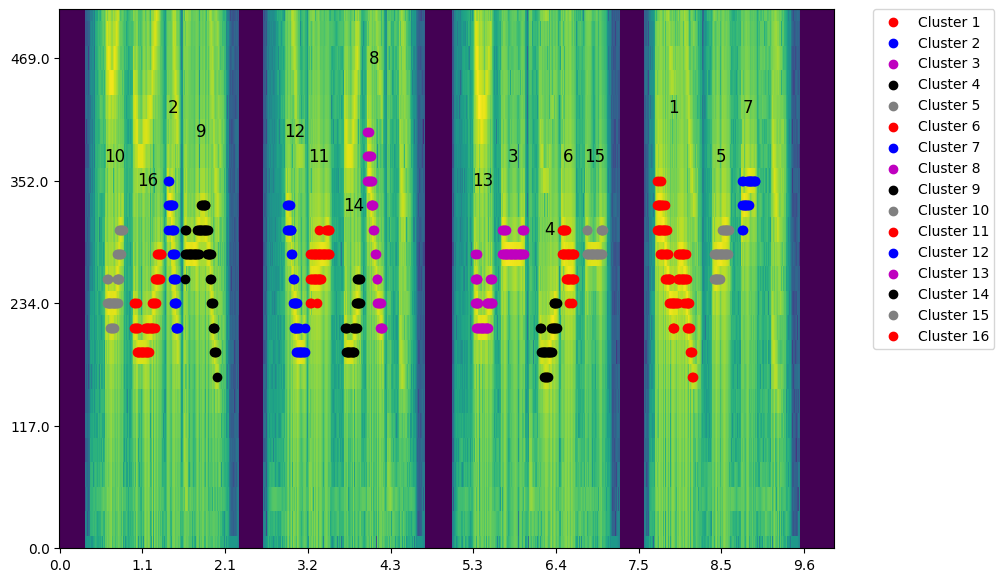

In [34]:
clusters = find_speech_clusters(audio_path, cutoff=500, min_brightness=0.70, min_points=17, max_vertical_distance=5, max_clusters=20)

In [15]:
'''for idx, cluster in enumerate(clusters):
    print(f'Cluster {idx+1} with {len(cluster)} points')
    print(cluster, '\n')'''

"for idx, cluster in enumerate(clusters):\n    print(f'Cluster {idx+1} with {len(cluster)} points')\n    print(cluster, '\n')"

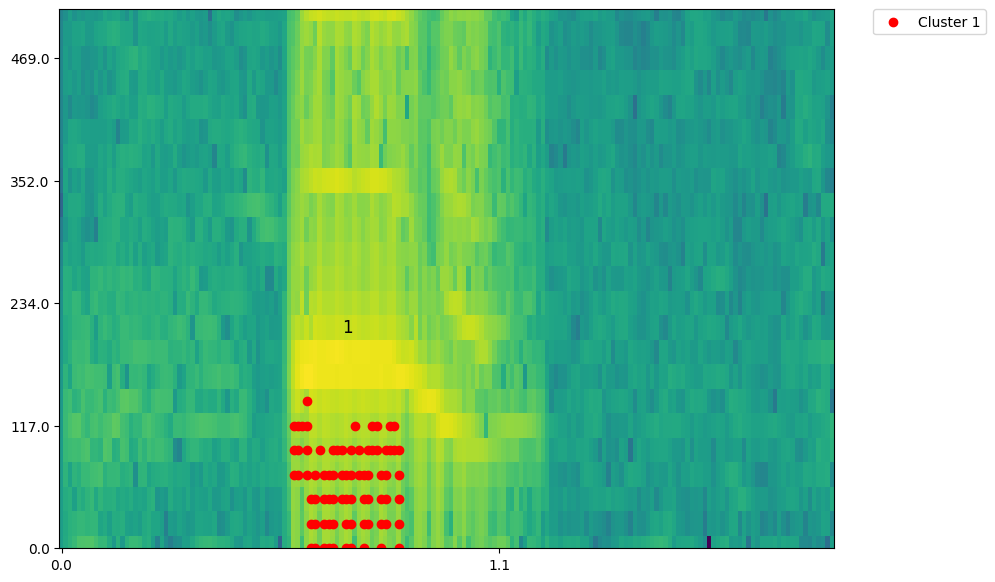

In [35]:
clusters = find_speech_clusters(audio_files[3], cutoff=500, min_brightness=0.70, min_points=17, max_vertical_distance=5, max_clusters=20)

In [ ]:
#consider brightness of clusters instead of just taking the lowest one

#consider an HDR layering approach over several sets of parameters, then take the best one

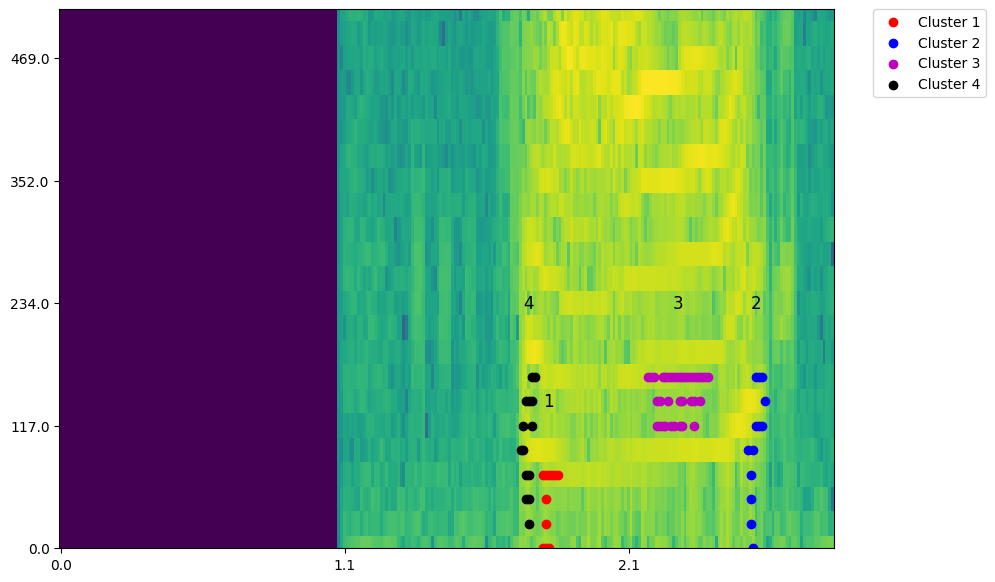

In [55]:

audio_path = glob('audio data/005794/005794_AY2122S2_week3_S038.wav')[0] #just for testing
clusters = find_speech_clusters(audio_path, cutoff=500, min_brightness=0.60, min_points=5, max_vertical_distance=5, max_clusters=50)

In [46]:
for idx, cluster in enumerate(clusters):
    print(f'Cluster {idx+1} with {len(cluster)} points')
    print(cluster, '\n')

Cluster 1 with 31 points
[(7, 174), (7, 173), (7, 175), (8, 173), (7, 172), (8, 172), (7, 176), (7, 171), (6, 171), (8, 171), (7, 177), (7, 170), (8, 170), (7, 178), (7, 169), (8, 169), (7, 179), (7, 168), (8, 168), (7, 180), (7, 181), (7, 182), (7, 183), (7, 184), (7, 185), (7, 186), (7, 187), (7, 188), (6, 188), (7, 189), (6, 189)] 

Cluster 2 with 40 points
[(7, 211), (7, 210), (7, 212), (8, 210), (7, 209), (8, 209), (7, 213), (7, 208), (8, 208), (7, 214), (7, 207), (8, 207), (7, 215), (6, 215), (7, 206), (8, 206), (7, 216), (6, 216), (7, 217), (7, 218), (7, 219), (7, 220), (7, 221), (7, 222), (7, 223), (7, 224), (7, 225), (7, 226), (7, 227), (7, 228), (7, 229), (7, 230), (7, 231), (7, 232), (7, 233), (6, 233), (7, 234), (6, 234), (6, 235), (6, 236)] 

Cluster 3 with 26 points
[(382, 162), (383, 162), (382, 161), (382, 163), (383, 161), (384, 162), (384, 161), (382, 160), (381, 160), (383, 160), (384, 160), (385, 161), (385, 160), (385, 159), (386, 161), (386, 162), (386, 163), (387